## Analysis of panel intersections

This notebook analyzes the users present in both the Northeastern panel and the Pew panel.

In [1]:
import pandas as pd
import numpy as np
from definitions import DEMOG_FILE, DEMOG_SCHEMA, EXTERNAL_DATA_DIR, WRU_IMPUTATIONS_FILE
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.float_format', '{:.2f}'.format)

# Intersection of NEU and Survey 2

In [2]:
hashes = pd.read_csv("./hash/hashed_neu_twids_v2.txt", sep="\t", names=["id", "hash"], dtype="str")
demog = pd.read_csv(DEMOG_FILE, sep='\t', names=list(DEMOG_SCHEMA.keys()), dtype=DEMOG_SCHEMA)
pew_demog = pd.read_csv(f"{EXTERNAL_DATA_DIR}/atp_matches_tweets.csv", dtype={'id': 'str', 'total_tweets': np.int64})

In [3]:
pew_demog = pew_demog.merge(hashes, "left", "hash")
atp_df = pew_demog.merge(demog, "left", "id")

# bring in WRU here before dropping ID
atp_df.race.fillna("Uncoded", inplace=True)
wru = pd.read_csv(WRU_IMPUTATIONS_FILE,
                  sep='\t',
                  dtype={'id_str': 'str'}).rename({'id_str': 'id'}, axis=1)
wru['imputed_race'] = wru['imputed_race']

atp_df = atp_df.merge(wru, how='left', on='id').drop(['pred.whi', 'pred.bla', 'pred.his', 'pred.asi', 'pred.oth'], axis=1)


atp_df = atp_df.drop("id", axis=1)

In [4]:
atp_df.drop(columns=['hash', 'total_tweets', 'total_followings', 'n_tweets', 'first_tweet', 'last_tweet', 'user_created_at', 'state', 'statuses_count', 'favourites_count', 'followers_count', 'friends_count']).head()

,Unnamed: 0,F_SEX,F_PARTY_FINAL,F_AGECAT,F_RACETHN,total_followers,one_impeach,num_tweets,age,gender,race,party,cd,zip,county_fips,partisan_score,registration_status,verified,imputed_race
0,1,Male,Democrat,50-64,Other,40,0,26,55.00,Male,Caucasian,Democrat,3.00,87505,49,99.40,1.00,False,Caucasian
1,2,Male,Democrat,65+,White non-Hispanic,2360,0,2736,68.00,Male,Caucasian,Democrat,12.00,28269,119,97.40,1.00,False,Caucasian
2,3,Male,Democrat,65+,White non-Hispanic,1680,0,4624,65.00,Female,Caucasian,Democrat,12.00,10022,61,97.80,1.00,True,Caucasian
3,4,Female,Democrat,50-64,White non-Hispanic,40,0,774,50.00,Female,Caucasian,Unaffiliated,4.00,45365,149,52.10,1.00,False,Caucasian
4,5,Male,Independent,65+,White non-Hispanic,20,0,93,67.00,Male,Caucasian,Unaffiliated,15.00,62995,87,8.50,1.00,False,Caucasian


### Gender

In [5]:
gender = atp_df.loc[:, ["hash", "F_SEX", "gender"]]
gender[gender['gender'] == "Unknown"] = np.nan

In [6]:
gender.groupby("F_SEX").gender.value_counts(dropna=False)

F_SEX   gender
Female  Female    31
        NaN        2
Male    Male      33
        NaN        4
        Female     2
Name: gender, dtype: int64

In [7]:
gender['gender_match'] = gender['F_SEX'] == gender["gender"]
gender.loc[pd.isnull(gender['gender']), 'gender_match'] = np.nan
gender['gender_match'].value_counts(dropna=False)

1.00    64
nan      7
0.00     2
Name: gender_match, dtype: int64

(That is, 64 matches agree on sex, 2 do not, and there's missing data on the NEU side for 7 people.)

In [8]:
gender['gender_match'].value_counts(dropna=True, normalize=True)

1.00   0.97
0.00   0.03
Name: gender_match, dtype: float64

In [9]:
gender.groupby(["F_SEX", "gender"]).agg({"gender_match": "count"})

gender_match
F_SEX  gender              
Female Female            31
Male   Female             2
       Male              33

In [10]:
gender_counts = gender.groupby(["F_SEX", "gender"]).agg({"gender_match": "count"})
gender_counts = gender_counts.reset_index().pivot("F_SEX", "gender", "gender_match").fillna(0)
gender_counts

gender,Female,Male
F_SEX,,
Female,31.00,0.00
Male,2.00,33.00


In [11]:
gender_counts = gender_counts.div(gender_counts.sum(axis=1), axis=0)

Text(0.5, 51.0, 'NEU Sex Reg')

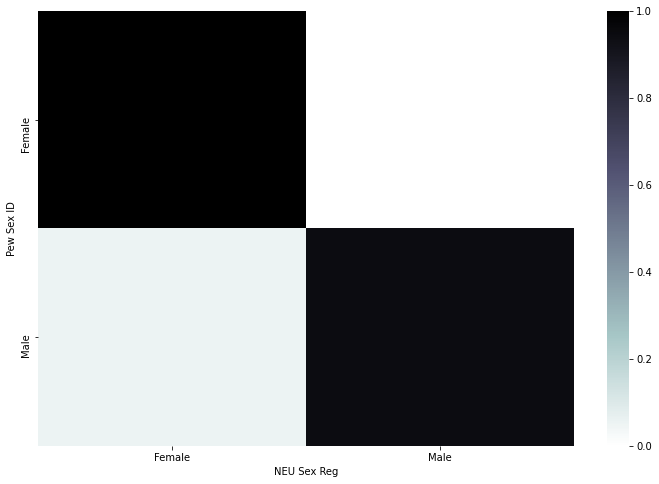

In [12]:
fig, ax = plt.subplots(figsize = (12, 8), facecolor='w')
sns.heatmap(gender_counts, cmap="bone_r", vmin=0, vmax=1, ax=ax)
ax.set_ylabel("Pew Sex ID")
ax.set_xlabel("NEU Sex Reg")

Where there's no missingness, sex agrees almost perfectly. The disagreements are self-identified males in the Pew data being recorded as female in the NEU data.

### Race

In [13]:
atp_df['pew_race'] = atp_df.race.replace({
    'Caucasian': 'White non-Hispanic',
    'Hispanic': 'Hispanic',
    'Uncoded': np.nan, 
    
    'Asian': 'Other', 
    'African-American': 'Black non-Hispanic',
    'Native American': 'Other',
})

In [14]:
race = atp_df.loc[:, ['hash', 'pew_race', 'F_RACETHN']]
race['race_match'] = race['pew_race'] == race['F_RACETHN']
race.loc[pd.isnull(race['pew_race']), "race_match"] = np.nan

In [15]:
race.fillna("Unknown").groupby("F_RACETHN").pew_race.value_counts()

F_RACETHN           pew_race          
Black non-Hispanic  Black non-Hispanic     2
                    Other                  1
                    Unknown                1
                    White non-Hispanic     1
Hispanic            Hispanic               7
                    White non-Hispanic     2
                    Unknown                1
Other               White non-Hispanic     3
                    Unknown                2
                    Other                  1
White non-Hispanic  White non-Hispanic    46
                    Unknown                4
                    Hispanic               1
                    Other                  1
Name: pew_race, dtype: int64

In [16]:
race.race_match.value_counts(dropna=False)

1.00    56
0.00     9
nan      8
Name: race_match, dtype: int64

In [17]:
race.race_match.value_counts(normalize=True, dropna=True)

1.00   0.86
0.00   0.14
Name: race_match, dtype: float64

In [18]:
race.groupby(["F_RACETHN", "pew_race"]).agg({"race_match": "count"})

race_match
F_RACETHN          pew_race                      
Black non-Hispanic Black non-Hispanic           2
                   Other                        1
                   White non-Hispanic           1
Hispanic           Hispanic                     7
                   White non-Hispanic           2
Other              Other                        1
                   White non-Hispanic           3
White non-Hispanic Hispanic                     1
                   Other                        1
                   White non-Hispanic          46

In [19]:
race_counts = race.groupby(["F_RACETHN", "pew_race"]).agg({"race_match": "count"})
race_counts = race_counts.reset_index().pivot("F_RACETHN", "pew_race", "race_match").fillna(0)
race_counts

pew_race,Black non-Hispanic,Hispanic,Other,White non-Hispanic
F_RACETHN,,,,
Black non-Hispanic,2.00,0.00,1.00,1.00
Hispanic,0.00,7.00,0.00,2.00
Other,0.00,0.00,1.00,3.00
White non-Hispanic,0.00,1.00,1.00,46.00


In [20]:
race_counts = race_counts.div(race_counts.sum(axis=1), axis=0)

Text(0.5, 51.0, 'NEU Race Reg')

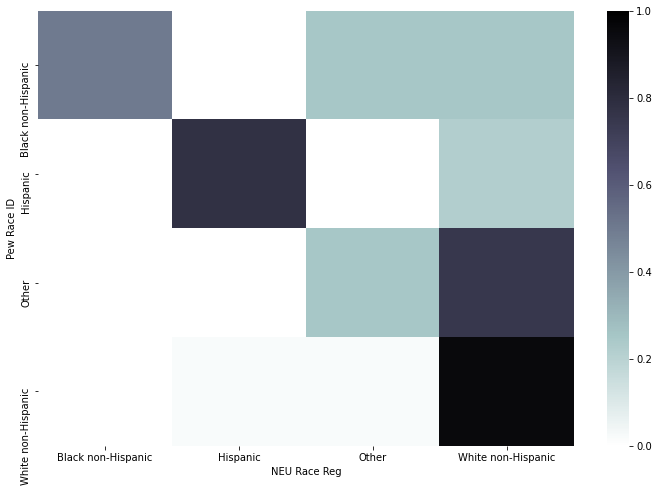

In [21]:
fig, ax = plt.subplots(figsize = (12, 8), facecolor='w')
sns.heatmap(race_counts, cmap="bone_r", vmin=0, vmax=1, ax=ax)
ax.set_ylabel("Pew Race ID")
ax.set_xlabel("NEU Race Reg")

(A note on interpretation: the rows each sum to 1. That is, the first row summarizes the proportion of Pew-coded Black Americans who are recorded as, respectively, Black, Hispanic, Other, White. Where agreement is high, the diagonal will be darker and the off-diagonal will be lighter.)

#### WRU

In [22]:
atp_df['pew_imputed_race'] = atp_df.imputed_race.replace({
    'Caucasian': 'White non-Hispanic',
    'Hispanic': 'Hispanic',
    'Uncoded': np.nan, # degree of freedom?
    'Asian': 'Other', # is this right? it's probably not right
    'African-American': 'Black non-Hispanic',
    'Native American': 'Other',
})

In [23]:
atp_df.imputed_race.value_counts()

Caucasian           51
Hispanic             7
Asian                2
African-American     2
Other                1
Name: imputed_race, dtype: int64

In [24]:
imputed_race = atp_df.loc[:, ['hash', 'pew_imputed_race', 'F_RACETHN']]
imputed_race['race_match'] = imputed_race['pew_imputed_race'] == imputed_race['F_RACETHN']
imputed_race.loc[pd.isnull(imputed_race['pew_imputed_race']), "race_match"] = np.nan

In [25]:
imputed_race.race_match.value_counts(dropna=False)

1.00    51
0.00    12
nan     10
Name: race_match, dtype: int64

In [26]:
imputed_race.race_match.value_counts(normalize=True, dropna=True)

1.00   0.81
0.00   0.19
Name: race_match, dtype: float64

In [27]:
imputed_race.groupby(["F_RACETHN", "pew_imputed_race"]).agg({"race_match": "count"})

race_match
F_RACETHN          pew_imputed_race              
Black non-Hispanic Black non-Hispanic           1
                   White non-Hispanic           3
Hispanic           Hispanic                     5
                   White non-Hispanic           3
Other              Other                        3
                   White non-Hispanic           3
White non-Hispanic Black non-Hispanic           1
                   Hispanic                     2
                   White non-Hispanic          42

In [28]:
imputed_race_counts = imputed_race.groupby(["F_RACETHN", "pew_imputed_race"]).agg({"race_match": "count"})
imputed_race_counts = imputed_race_counts.reset_index().pivot("F_RACETHN", "pew_imputed_race", "race_match").fillna(0)
imputed_race_counts

pew_imputed_race,Black non-Hispanic,Hispanic,Other,White non-Hispanic
F_RACETHN,,,,
Black non-Hispanic,1.00,0.00,0.00,3.00
Hispanic,0.00,5.00,0.00,3.00
Other,0.00,0.00,3.00,3.00
White non-Hispanic,1.00,2.00,0.00,42.00


In [29]:
imputed_race_counts = imputed_race_counts.div(imputed_race_counts.sum(axis=1), axis=0)

Text(0.5, 51.0, 'NEU Imputed Race')

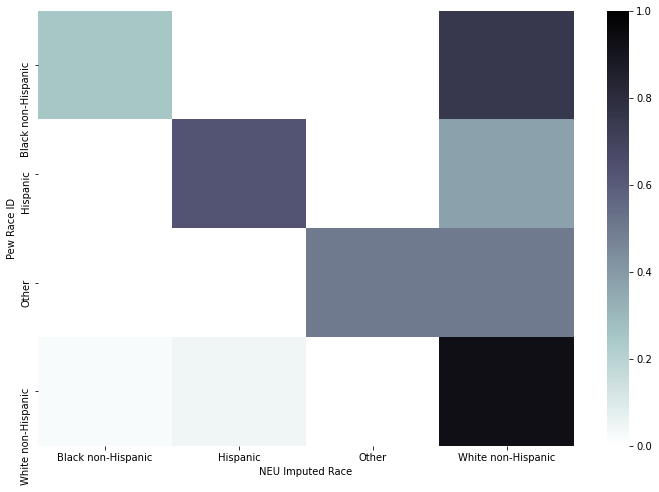

In [30]:
fig, ax = plt.subplots(figsize = (12, 8), facecolor='w')
sns.heatmap(imputed_race_counts, cmap="bone_r", vmin=0, vmax=1, ax=ax)
ax.set_ylabel("Pew Race ID")
ax.set_xlabel("NEU Imputed Race")

### Party

In [31]:
atp_df['pew_party'] = atp_df.party.replace({
    'Unaffiliated': 'Independent',
    'Other': 'Something else',
    'Libertarian': 'Something else',
    'No Party': 'Independent'
})

In [32]:
party = atp_df.loc[:, ["hash", "F_PARTY_FINAL", "pew_party"]]
party['party_match'] = party['F_PARTY_FINAL'] == party['pew_party']
party.loc[pd.isnull(party["pew_party"]), "party_match"] = np.nan

In [33]:
party.party_match.value_counts(dropna=False)

0.00    37
1.00    29
nan      7
Name: party_match, dtype: int64

In [34]:
party.party_match.value_counts(normalize=True, dropna=True)

0.00   0.56
1.00   0.44
Name: party_match, dtype: float64

In [35]:
party.groupby(["F_PARTY_FINAL", "pew_party"]).agg({"party_match": "count"})

party_match
F_PARTY_FINAL  pew_party                  
Democrat       Democrat                 13
               Independent              16
               Republican                1
Independent    Democrat                  3
               Independent               9
               Republican                1
               Something else            2
Republican     Democrat                  1
               Independent               7
               Republican                7
Something else Independent               4
               Republican                2

In [36]:
party.fillna("Unknown").groupby("F_PARTY_FINAL").pew_party.value_counts()

F_PARTY_FINAL   pew_party     
Democrat        Independent       16
                Democrat          13
                Unknown            3
                Republican         1
Independent     Independent        9
                Democrat           3
                Unknown            3
                Something else     2
                Republican         1
Republican      Independent        7
                Republican         7
                Democrat           1
                Unknown            1
Something else  Independent        4
                Republican         2
Name: pew_party, dtype: int64

In [37]:
party_counts = party.groupby(["F_PARTY_FINAL", "pew_party"]).agg({"party_match": "count"})
party_counts = party_counts.reset_index().pivot("F_PARTY_FINAL", "pew_party", "party_match").fillna(0)
party_counts

pew_party,Democrat,Independent,Republican,Something else
F_PARTY_FINAL,,,,
Democrat,13.00,16.00,1.00,0.00
Independent,3.00,9.00,1.00,2.00
Republican,1.00,7.00,7.00,0.00
Something else,0.00,4.00,2.00,0.00


In [38]:
party_counts = party_counts.div(party_counts.sum(axis=1), axis=0)

Text(0.5, 51.0, 'NEU Party Reg')

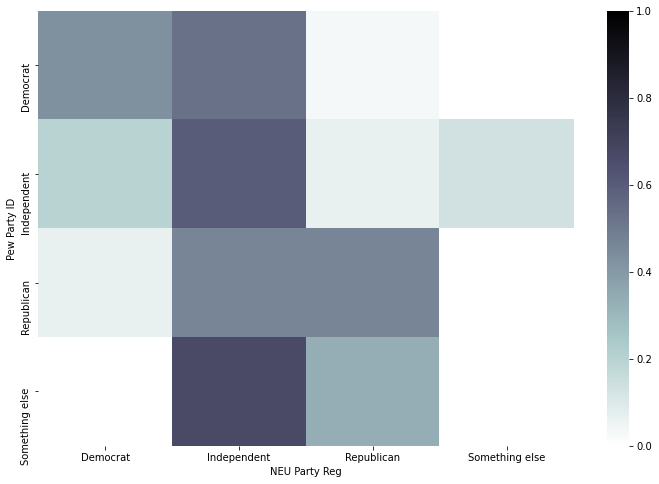

In [39]:
fig, ax = plt.subplots(figsize = (12, 8), facecolor='w')
sns.heatmap(party_counts, cmap="bone_r", vmin=0, vmax=1, ax=ax)
ax.set_ylabel("Pew Party ID")
ax.set_xlabel("NEU Party Reg")

#### TSmart Party

In [40]:
atp_df['tsmart_party'] = pd.cut(atp_df['partisan_score'].astype(np.float64), [0, 36, 65, 100], labels=["Republican", "Independent", "Democrat"])

In [41]:
atp_df['pew_tsmart_party'] = atp_df.tsmart_party.replace({
    'Unaffiliated': 'Independent',
    'Other': 'Something else',
    'Libertarian': 'Something else',
    'No Party': 'Independent'
})

In [42]:
tsmart_party = atp_df.loc[:, ["hash", "F_PARTY_FINAL", "pew_tsmart_party"]]
tsmart_party['tsmart_party_match'] = tsmart_party['F_PARTY_FINAL'] == tsmart_party['pew_tsmart_party']
tsmart_party.loc[pd.isnull(tsmart_party["pew_tsmart_party"]), "tsmart_party_match"] = np.nan

In [43]:
tsmart_party.tsmart_party_match.value_counts(dropna=False)

0.00    35
1.00    32
nan      6
Name: tsmart_party_match, dtype: int64

In [44]:
tsmart_party.tsmart_party_match.value_counts(normalize=True, dropna=True)

0.00   0.52
1.00   0.48
Name: tsmart_party_match, dtype: float64

In [45]:
tsmart_party.groupby(["F_PARTY_FINAL", "pew_tsmart_party"]).agg({"tsmart_party_match": "count"})

tsmart_party_match
F_PARTY_FINAL  pew_tsmart_party                    
Democrat       Republican                         5
               Independent                        5
               Democrat                          20
Independent    Republican                         8
               Independent                        1
               Democrat                           7
Republican     Republican                        11
               Independent                        2
               Democrat                           2
Something else Republican                         3
               Independent                        0
               Democrat                           3

In [46]:
tsmart_party_counts = tsmart_party.groupby(["F_PARTY_FINAL", "pew_tsmart_party"]).agg({"tsmart_party_match": "count"})
tsmart_party_counts = tsmart_party_counts.reset_index().pivot("F_PARTY_FINAL", "pew_tsmart_party", "tsmart_party_match").fillna(0)

# TSmart partisan score doesn't give a "Something else", so all this is just fussing
# around with the Index to play nice.
tsmart_party_counts.columns = tsmart_party_counts.columns.as_unordered().add_categories("Something else")
tsmart_party_counts.loc[:, "Something else"] = [0,0,0,0]
tsmart_party_counts.index = tsmart_party_counts.index.sort_values()

tsmart_party_counts

pew_tsmart_party,Republican,Independent,Democrat,Something else
F_PARTY_FINAL,,,,
Democrat,5,5,20,0
Independent,8,1,7,0
Republican,11,2,2,0
Something else,3,0,3,0


In [47]:
tsmart_party_counts = tsmart_party_counts.div(tsmart_party_counts.sum(axis=1), axis=0)#.reset_index()

In [48]:
tsmart_party_counts = tsmart_party_counts.loc[:, ["Democrat", "Independent", "Republican", "Something else"]]

Text(0.5, 51.0, 'NEU Modeled Party')

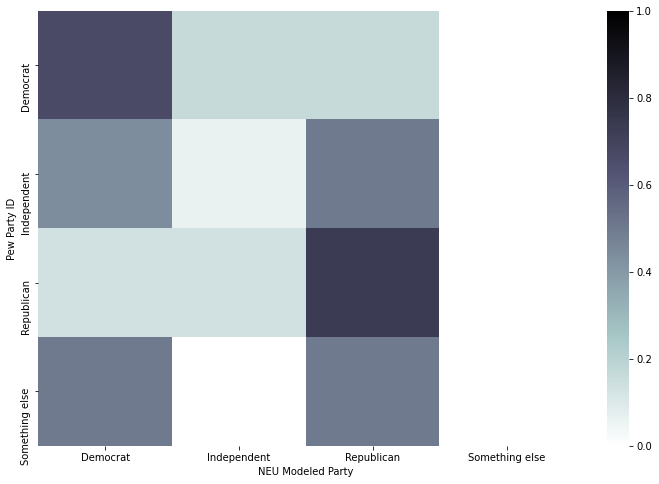

In [49]:
fig, ax = plt.subplots(figsize = (12, 8), facecolor='w')
sns.heatmap(tsmart_party_counts, cmap="bone_r", vmin=0, vmax=1, ax=ax)
ax.set_ylabel("Pew Party ID")
ax.set_xlabel("NEU Modeled Party")

### Age

In [50]:
atp_df.F_AGECAT.value_counts()

30-49    28
50-64    21
18-29    14
65+      10
Name: F_AGECAT, dtype: int64

In [51]:
atp_df['shifted_age'] = atp_df['age'] + 2
atp_df['pew_age'] = pd.cut(atp_df.shifted_age, [0, 17, 29, 49, 64, 130]).astype('str').replace({
    "(49.0, 64.0]": '50-64',
    "(0.0, 17.0]": "<18",
    "(17.0, 29.0]": "18-29",
    "(64.0, 130.0]": "65+",
    "(29.0, 49.0]": "30-49",
    "nan": np.nan
})

(Note that the voter-file age is shifted by two because the Pew surveys were conducted in 2019 and the voter file dates from 2017.)

In [52]:
age = atp_df.loc[:, ["hash", "shifted_age", 'pew_age', 'F_AGECAT']]
age['age_match'] = age['pew_age'] == age['F_AGECAT']
age.loc[pd.isnull(age["pew_age"]), "age_match"] = np.nan

In [53]:
age.age_match.value_counts(dropna=False)

1.00    63
nan      7
0.00     3
Name: age_match, dtype: int64

In [54]:
age.age_match.value_counts(normalize=True, dropna=True)

1.00   0.95
0.00   0.05
Name: age_match, dtype: float64

In [55]:
age.groupby(["F_AGECAT", "pew_age"]).agg({"age_match": "count"})

age_match
F_AGECAT pew_age           
18-29    18-29           12
         50-64            1
30-49    30-49           23
         50-64            1
50-64    30-49            1
         50-64           18
65+      65+             10

In [56]:
age['F_AGECAT'] = pd.Categorical(age['F_AGECAT'])

Text(0, 0.5, 'Pew Age')

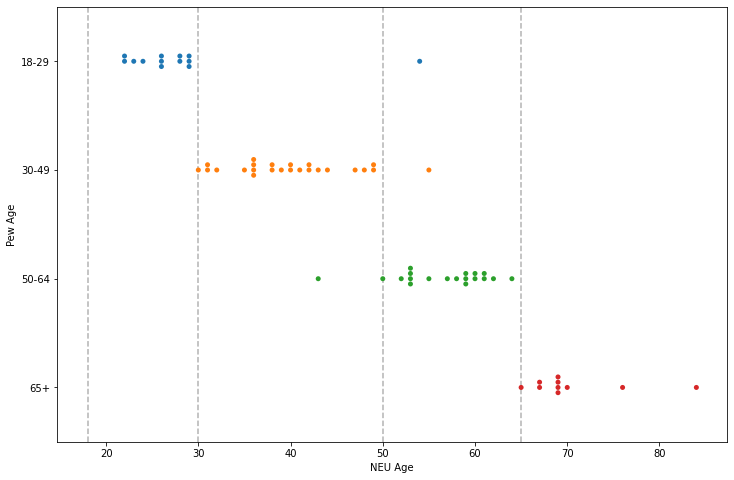

In [57]:
fig, ax = plt.subplots(figsize=(12, 8), facecolor='w')
sns.swarmplot('shifted_age', 'F_AGECAT', data=age, ax=ax)
for boundary in [18, 30, 50, 65]:
    ax.axvline(boundary, linestyle='--', color="black", alpha=0.3)
ax.set_xlabel("NEU Age")
ax.set_ylabel("Pew Age")

### Combined match rates

In [58]:
all_match = gender.merge(party).merge(age).merge(race).loc[:, ["gender_match", "party_match", "age_match", "race_match"]]

In [59]:
all_match_no_na = all_match[pd.notnull(all_match).all(axis=1)]
print(len(all_match_no_na))
print(len(all_match[pd.notnull(all_match).any(axis=1)]))

63
66


There are 10 IDs for which there is at least one missing value. (For 7 of these, they're all missing.)

In [60]:
all_match_no_na.sum(axis=1).value_counts(normalize=True)

3.00   0.51
4.00   0.37
2.00   0.11
1.00   0.02
dtype: float64

Mismatches are not concentrated to a few problematic records (aside from the missing ones).

## Behavior

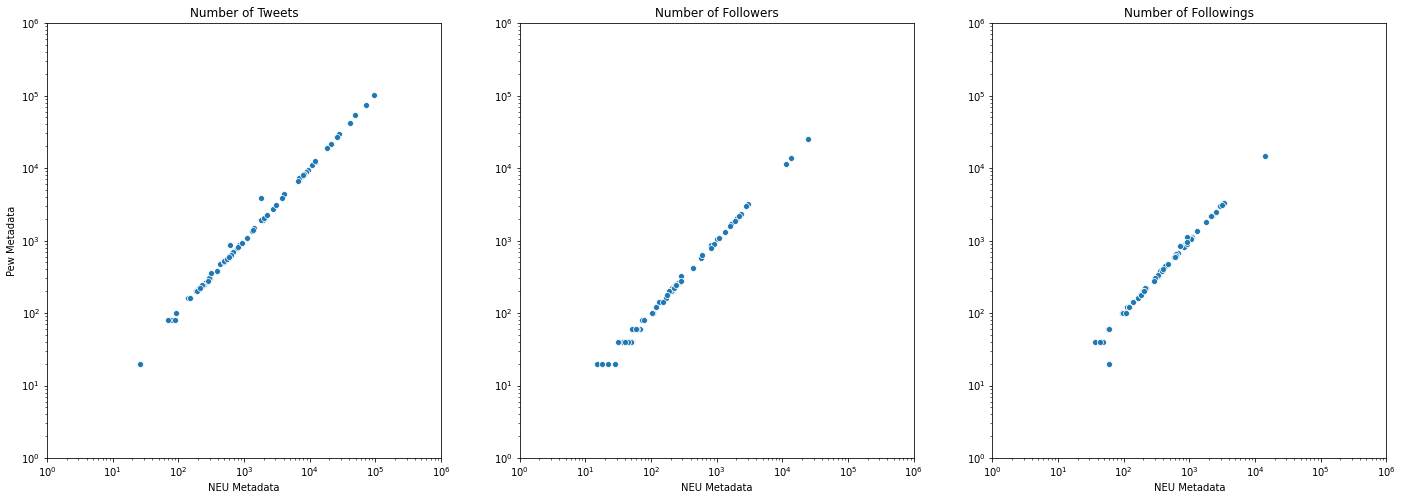

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), facecolor='w')

sns.scatterplot("statuses_count", "total_tweets", data=atp_df, ax=ax1)
sns.scatterplot("followers_count", "total_followers", data=atp_df, ax=ax2)
sns.scatterplot("friends_count", "total_followings", data=atp_df, ax=ax3)
for ax in (ax1, ax2, ax3):
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(1, 10**6)
    ax.set_ylim(1, 10**6)
    ax.set_xlabel("NEU Metadata")
    ax.set_ylabel("")
ax1.set_ylabel("Pew Metadata")
ax1.set_title("Number of Tweets")
ax2.set_title("Number of Followers")
ax3.set_title("Number of Followings")

fig.show()

As expected, metadata-based behavioral measures agree nearly perfectly.

# Re-do the whole analysis on Survey 1

In [62]:
hashes = pd.read_csv("./hash/hashed_neu_twids_v2.txt", sep="\t", names=["id", "hash"], dtype="str")
demog = pd.read_csv(DEMOG_FILE, sep='\t', names=list(DEMOG_SCHEMA.keys()), dtype=DEMOG_SCHEMA)
#pew_demog = pd.read_csv(f"{EXTERNAL_DATA_DIR}/panel_intersection.csv", dtype={'id': 'str', 'total_tweets': np.int64})
pew_demog = pd.read_csv(f"{EXTERNAL_DATA_DIR}/kp_matches_tweets.csv", dtype={'id': 'str', 'total_tweets': np.int64})

In [63]:
pew_demog = pew_demog.merge(hashes, "left", "hash")
kp_df = pew_demog.merge(demog, "left", "id")

# bring in WRU here before dropping ID
kp_df.race.fillna("Uncoded", inplace=True)
wru = pd.read_csv(WRU_IMPUTATIONS_FILE,
                  sep='\t',
                  dtype={'id_str': 'str'}).rename({'id_str': 'id'}, axis=1)
wru['imputed_race'] = wru['imputed_race']

kp_df = kp_df.merge(wru, how='left', on='id').drop(['pred.whi', 'pred.bla', 'pred.his', 'pred.asi', 'pred.oth'], axis=1)

# def combine_race(ts, wru):
#     if ts == "Uncoded": # NOTE/TODO: could be ['Uncoded', 'Other']
#         return wru
#     else:
#         return ts

# kp_df['combined_race'] = kp_df.apply(lambda x: combine_race(x['race'], x['imputed_race']), axis=1)

kp_df = kp_df.drop("id", axis=1)
kp_df.head()

,Unnamed: 0,hash,F_SEX,F_PARTY_FINAL,F_AGECAT,F_RACETHN,total_tweets,total_followings,total_followers,n_tweets,...,registration_status,first_tweet,last_tweet,statuses_count,favourites_count,followers_count,friends_count,user_created_at,verified,imputed_race
0,1,fae7a4ad59a4dd39985a4674f621b54d87662b9e1b13c5...,Male,Democrat,30-49,White non-Hispanic,2820,360,100,0,...,1.00,1236224959,1572621667,2819.00,161.00,98.00,362.00,Thu Mar 05 03:47:36 +0000 2009,False,Asian
1,2,4b39107eb4277f04f86a0d0d279bb5cbb61fa314ccd9cd...,Female,Republican,30-49,White non-Hispanic,460,0,0,0,...,0.00,1238799570,1545697366,470.00,74.00,2.00,9.00,Fri Apr 03 22:46:22 +0000 2009,False,NaN
2,3,f0cafcbc6b1d55bc767fa59f76e62244842dc655fb640e...,Male,Something else,18-29,White non-Hispanic,100,80,40,0,...,1.00,1381927408,1571145062,96.00,37.00,40.00,77.00,Wed Oct 16 04:55:09 +0000 2013,False,Caucasian
3,4,9633b3a5cebd1513b5ec598dd2a181b63c20109477ff8c...,Female,Democrat,30-49,White non-Hispanic,320,560,40,0,...,1.00,1293750095,1572853048,329.00,21.00,45.00,559.00,Thu Sep 03 22:18:45 +0000 2009,False,Caucasian
4,5,c653972c72dbc0d9f2a2aa8425a13ae006a9b06e4fd43c...,Female,Democrat,30-49,White non-Hispanic,1040,160,80,0,...,1.00,1316652322,1572048467,1038.00,293.00,84.00,153.00,Sat Jun 06 01:41:57 +0000 2009,False,Caucasian


### Gender

In [64]:
gender = kp_df.loc[:, ["hash", "F_SEX", "gender"]]
gender[gender['gender'] == "Unknown"] = np.nan

In [65]:
gender['gender_match'] = gender['F_SEX'] == gender["gender"]
gender.loc[pd.isnull(gender['gender']), 'gender_match'] = np.nan
gender['gender_match'].value_counts(dropna=False)

1.00    98
nan      7
0.00     3
Name: gender_match, dtype: int64

(That is, 64 matches agree on sex, 2 do not, and there's missing data on the NEU side for 7 people.)

In [66]:
gender['gender_match'].value_counts(dropna=True, normalize=True)

1.00   0.97
0.00   0.03
Name: gender_match, dtype: float64

In [67]:
gender.groupby(["F_SEX", "gender"]).agg({"gender_match": "count"})

gender_match
F_SEX  gender              
Female Female            59
       Male               1
Male   Female             2
       Male              39

In [68]:
gender.fillna("Unknown").groupby("F_SEX").gender.value_counts(dropna=False)

F_SEX    gender 
Female   Female     59
         Male        1
         Unknown     1
Male     Male       39
         Female      2
         Unknown     1
Unknown  Unknown     5
Name: gender, dtype: int64

In [69]:
gender_counts = gender.groupby(["F_SEX", "gender"]).agg({"gender_match": "count"})
gender_counts = gender_counts.reset_index().pivot("F_SEX", "gender", "gender_match").fillna(0)
gender_counts

gender,Female,Male
F_SEX,,
Female,59,1
Male,2,39


In [70]:
gender_counts = gender_counts.div(gender_counts.sum(axis=1), axis=0)

Text(0.5, 51.0, 'NEU Sex Reg')

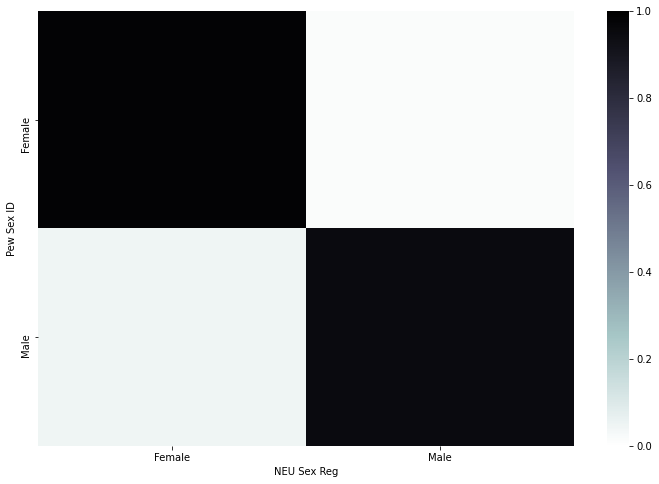

In [71]:
fig, ax = plt.subplots(figsize = (12, 8), facecolor='w')
sns.heatmap(gender_counts, cmap="bone_r", vmin=0, vmax=1, ax=ax)
ax.set_ylabel("Pew Sex ID")
ax.set_xlabel("NEU Sex Reg")

Where there's no missingness, sex agrees almost perfectly. The disagreements are self-identified males in the Pew data being recorded as female in the NEU data.

### Race

In [72]:
kp_df['pew_race'] = kp_df.race.replace({
    'Caucasian': 'White non-Hispanic',
    'Hispanic': 'Hispanic',
    'Uncoded': np.nan, # degree of freedom?
    'Asian': 'Other', # is this right? it's probably not right
    'African-American': 'Black non-Hispanic',
    'Native American': 'Other',
})

In [73]:
race = kp_df.loc[:, ['hash', 'pew_race', 'F_RACETHN']]
race['race_match'] = race['pew_race'] == race['F_RACETHN']
race.loc[pd.isnull(race['pew_race']), "race_match"] = np.nan

In [74]:
race.race_match.value_counts(dropna=False)

1.00    91
0.00    12
nan      5
Name: race_match, dtype: int64

In [75]:
race.race_match.value_counts(normalize=True, dropna=True)

1.00   0.88
0.00   0.12
Name: race_match, dtype: float64

In [76]:
race.fillna("Unknown").groupby("F_RACETHN").pew_race.value_counts()

F_RACETHN           pew_race          
Black non-Hispanic  Black non-Hispanic     3
                    White non-Hispanic     3
                    Unknown                1
Hispanic            Hispanic               4
                    White non-Hispanic     3
Other               White non-Hispanic     4
                    Unknown                2
                    Black non-Hispanic     1
                    Other                  1
White non-Hispanic  White non-Hispanic    83
                    Unknown                2
                    Black non-Hispanic     1
Name: pew_race, dtype: int64

In [77]:
race.groupby(["F_RACETHN", "pew_race"]).agg({"race_match": "count"})

race_match
F_RACETHN          pew_race                      
Black non-Hispanic Black non-Hispanic           3
                   White non-Hispanic           3
Hispanic           Hispanic                     4
                   White non-Hispanic           3
Other              Black non-Hispanic           1
                   Other                        1
                   White non-Hispanic           4
White non-Hispanic Black non-Hispanic           1
                   White non-Hispanic          83

In [78]:
race_counts = race.groupby(["F_RACETHN", "pew_race"]).agg({"race_match": "count"})
race_counts = race_counts.reset_index().pivot("F_RACETHN", "pew_race", "race_match").fillna(0)
race_counts

pew_race,Black non-Hispanic,Hispanic,Other,White non-Hispanic
F_RACETHN,,,,
Black non-Hispanic,3.00,0.00,0.00,3.00
Hispanic,0.00,4.00,0.00,3.00
Other,1.00,0.00,1.00,4.00
White non-Hispanic,1.00,0.00,0.00,83.00


In [79]:
race_counts = race_counts.div(race_counts.sum(axis=1), axis=0)

Text(0.5, 51.0, 'NEU Race Reg')

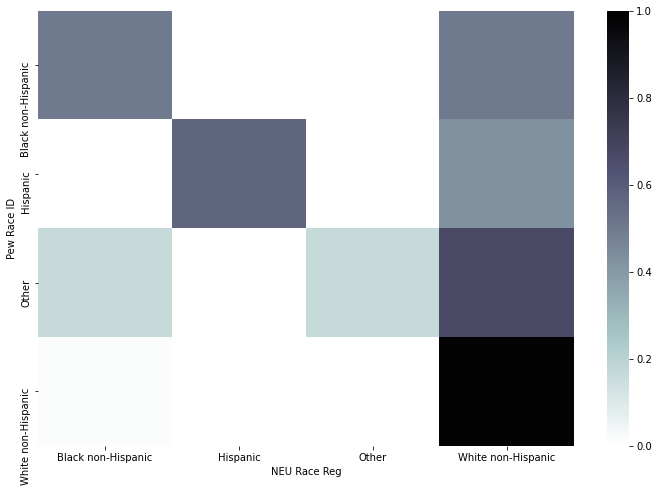

In [80]:
fig, ax = plt.subplots(figsize = (12, 8), facecolor='w')
sns.heatmap(race_counts, cmap="bone_r", vmin=0, vmax=1, ax=ax)
ax.set_ylabel("Pew Race ID")
ax.set_xlabel("NEU Race Reg")

(A note on interpretation: the rows each sum to 1. That is, the first row summarizes the proportion of Pew-coded Black Americans who are recorded as, respectively, Black, Hispanic, Other, White. Where agreement is high, the diagonal will be darker and the off-diagonal will be lighter.)

#### WRU

In [81]:
kp_df['pew_imputed_race'] = kp_df.imputed_race.replace({
    'Caucasian': 'White non-Hispanic',
    'Hispanic': 'Hispanic',
    'Uncoded': np.nan, # degree of freedom?
    'Asian': 'Other', # is this right? it's probably not right
    'African-American': 'Black non-Hispanic',
    'Native American': 'Other',
})

In [82]:
kp_df.imputed_race.value_counts()

Caucasian           90
Hispanic             5
Asian                2
African-American     2
Other                1
Name: imputed_race, dtype: int64

In [83]:
imputed_race = kp_df.loc[:, ['hash', 'pew_imputed_race', 'F_RACETHN']]
imputed_race['race_match'] = imputed_race['pew_imputed_race'] == imputed_race['F_RACETHN']
imputed_race.loc[pd.isnull(imputed_race['pew_imputed_race']), "race_match"] = np.nan

In [84]:
imputed_race.race_match.value_counts(dropna=False)

1.00    84
0.00    16
nan      8
Name: race_match, dtype: int64

In [85]:
imputed_race.race_match.value_counts(normalize=True, dropna=True)

1.00   0.84
0.00   0.16
Name: race_match, dtype: float64

In [86]:
imputed_race.groupby(["F_RACETHN", "pew_imputed_race"]).agg({"race_match": "count"})

race_match
F_RACETHN          pew_imputed_race              
Black non-Hispanic Black non-Hispanic           1
                   White non-Hispanic           5
Hispanic           Hispanic                     4
                   White non-Hispanic           3
Other              Black non-Hispanic           1
                   Other                        1
                   White non-Hispanic           4
White non-Hispanic Hispanic                     1
                   Other                        2
                   White non-Hispanic          78

In [87]:
imputed_race_counts = imputed_race.groupby(["F_RACETHN", "pew_imputed_race"]).agg({"race_match": "count"})
imputed_race_counts = imputed_race_counts.reset_index().pivot("F_RACETHN", "pew_imputed_race", "race_match").fillna(0)
imputed_race_counts

pew_imputed_race,Black non-Hispanic,Hispanic,Other,White non-Hispanic
F_RACETHN,,,,
Black non-Hispanic,1.00,0.00,0.00,5.00
Hispanic,0.00,4.00,0.00,3.00
Other,1.00,0.00,1.00,4.00
White non-Hispanic,0.00,1.00,2.00,78.00


In [88]:
imputed_race_counts = imputed_race_counts.div(imputed_race_counts.sum(axis=1), axis=0)

Text(0.5, 51.0, 'NEU Imputed Race')

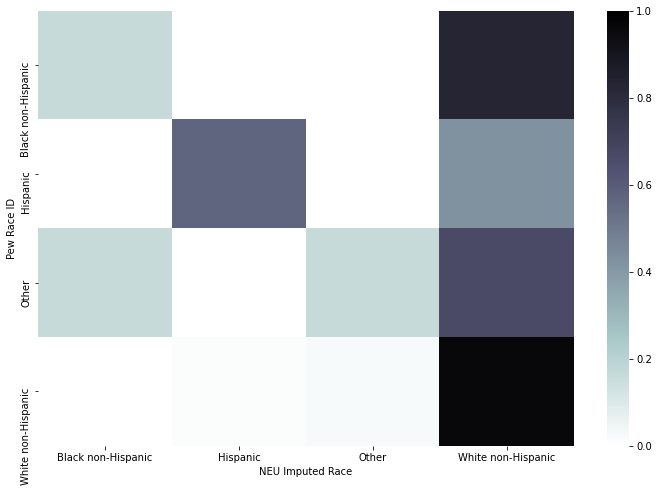

In [89]:
fig, ax = plt.subplots(figsize = (12, 8), facecolor='w')
sns.heatmap(imputed_race_counts, cmap="bone_r", vmin=0, vmax=1, ax=ax)
ax.set_ylabel("Pew Race ID")
ax.set_xlabel("NEU Imputed Race")

### Party

In [90]:
kp_df['pew_party'] = kp_df.party.replace({
    'Unaffiliated': 'Independent',
    'Other': 'Something else',
    'Libertarian': 'Something else',
    'No Party': 'Independent'
})

In [91]:
party = kp_df.loc[:, ["hash", "F_PARTY_FINAL", "pew_party"]]
party['party_match'] = party['F_PARTY_FINAL'] == party['pew_party']
party.loc[pd.isnull(party["pew_party"]), "party_match"] = np.nan

In [92]:
party.party_match.value_counts(dropna=False)

0.00    52
1.00    48
nan      8
Name: party_match, dtype: int64

In [93]:
party.party_match.value_counts(normalize=True, dropna=True)

0.00   0.52
1.00   0.48
Name: party_match, dtype: float64

In [94]:
party.groupby(["F_PARTY_FINAL", "pew_party"]).agg({"party_match": "count"})

party_match
F_PARTY_FINAL  pew_party                  
Democrat       Democrat                 20
               Independent              25
               Republican                1
Independent    Democrat                  3
               Independent              18
               Republican                5
               Something else            1
Republican     Democrat                  2
               Independent               8
               Republican               10
Something else Independent               5
               Republican                2

In [95]:
party.fillna("Unknown").groupby("F_PARTY_FINAL").pew_party.value_counts()

F_PARTY_FINAL   pew_party     
Democrat        Independent       25
                Democrat          20
                Unknown            2
                Republican         1
Independent     Independent       18
                Republican         5
                Democrat           3
                Something else     1
                Unknown            1
Republican      Republican        10
                Independent        8
                Unknown            3
                Democrat           2
Something else  Independent        5
                Republican         2
                Unknown            2
Name: pew_party, dtype: int64

In [96]:
party_counts = party.groupby(["F_PARTY_FINAL", "pew_party"]).agg({"party_match": "count"})
party_counts = party_counts.reset_index().pivot("F_PARTY_FINAL", "pew_party", "party_match").fillna(0)
party_counts

pew_party,Democrat,Independent,Republican,Something else
F_PARTY_FINAL,,,,
Democrat,20.00,25.00,1.00,0.00
Independent,3.00,18.00,5.00,1.00
Republican,2.00,8.00,10.00,0.00
Something else,0.00,5.00,2.00,0.00


In [97]:
party_counts = party_counts.div(party_counts.sum(axis=1), axis=0)

Text(0.5, 51.0, 'NEU Party Reg')

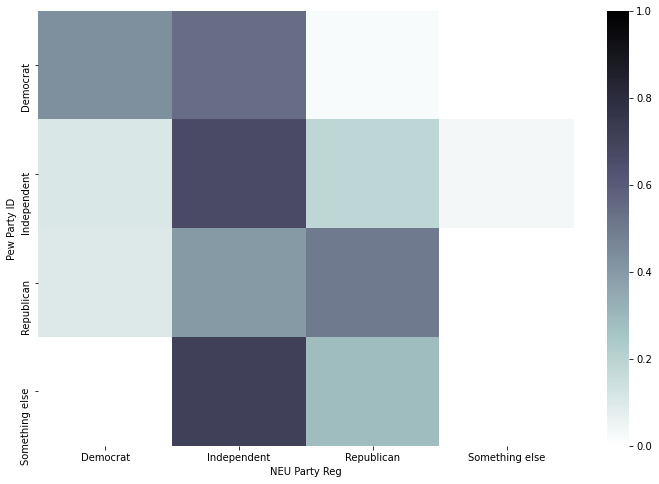

In [98]:
fig, ax = plt.subplots(figsize = (12, 8), facecolor='w')
sns.heatmap(party_counts, cmap="bone_r", vmin=0, vmax=1, ax=ax)
ax.set_ylabel("Pew Party ID")
ax.set_xlabel("NEU Party Reg")

#### TSmart Party

In [99]:
kp_df['tsmart_party'] = pd.cut(kp_df['partisan_score'].astype(np.float64), [0, 36, 65, 100], labels=["Republican", "Independent", "Democrat"])

In [100]:
kp_df['pew_tsmart_party'] = kp_df.tsmart_party.replace({
    'Unaffiliated': 'Independent',
    'Other': 'Something else',
    'Libertarian': 'Something else',
    'No Party': 'Independent'
})

In [101]:
tsmart_party = kp_df.loc[:, ["hash", "F_PARTY_FINAL", "pew_tsmart_party"]]
tsmart_party['tsmart_party_match'] = tsmart_party['F_PARTY_FINAL'] == tsmart_party['pew_tsmart_party']
tsmart_party.loc[pd.isnull(tsmart_party["pew_tsmart_party"]), "tsmart_party_match"] = np.nan

In [102]:
tsmart_party.tsmart_party_match.value_counts(dropna=False)

1.00    62
0.00    44
nan      2
Name: tsmart_party_match, dtype: int64

In [103]:
tsmart_party.tsmart_party_match.value_counts(normalize=True, dropna=True)

1.00   0.58
0.00   0.42
Name: tsmart_party_match, dtype: float64

In [104]:
tsmart_party.groupby(["F_PARTY_FINAL", "pew_tsmart_party"]).agg({"tsmart_party_match": "count"})

tsmart_party_match
F_PARTY_FINAL  pew_tsmart_party                    
Democrat       Republican                         4
               Independent                        2
               Democrat                          42
Independent    Republican                        12
               Independent                        6
               Democrat                          10
Republican     Republican                        14
               Independent                        3
               Democrat                           6
Something else Republican                         5
               Independent                        1
               Democrat                           1

In [105]:
tsmart_party_counts = tsmart_party.groupby(["F_PARTY_FINAL", "pew_tsmart_party"]).agg({"tsmart_party_match": "count"})
tsmart_party_counts = tsmart_party_counts.reset_index().pivot("F_PARTY_FINAL", "pew_tsmart_party", "tsmart_party_match").fillna(0)

# TSmart partisan score doesn't give a "Something else", so all this is just fussing
# around with the Index to play nice.
tsmart_party_counts.columns = tsmart_party_counts.columns.as_unordered().add_categories("Something else")
tsmart_party_counts.loc[:, "Something else"] = [0,0,0,0]
tsmart_party_counts.index = tsmart_party_counts.index.sort_values()

tsmart_party_counts

pew_tsmart_party,Republican,Independent,Democrat,Something else
F_PARTY_FINAL,,,,
Democrat,4,2,42,0
Independent,12,6,10,0
Republican,14,3,6,0
Something else,5,1,1,0


In [106]:
tsmart_party_counts = tsmart_party_counts.div(tsmart_party_counts.sum(axis=1), axis=0)#.reset_index()

In [107]:
tsmart_party_counts = tsmart_party_counts.loc[:, ["Democrat", "Independent", "Republican", "Something else"]]

Text(0.5, 51.0, 'NEU Modeled Party')

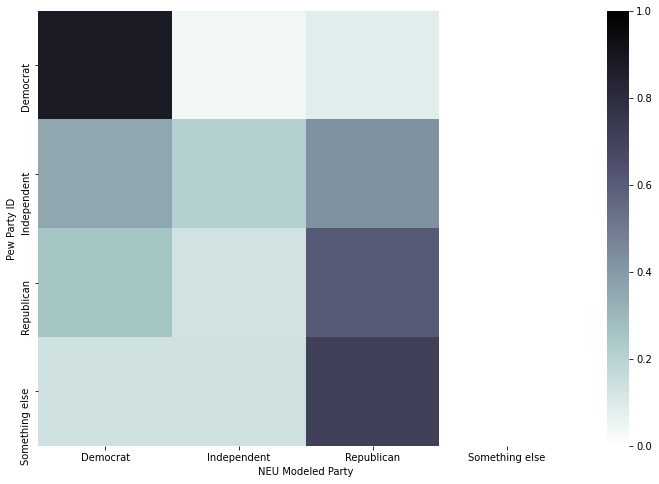

In [108]:
fig, ax = plt.subplots(figsize = (12, 8), facecolor='w')
sns.heatmap(tsmart_party_counts, cmap="bone_r", vmin=0, vmax=1, ax=ax)
ax.set_ylabel("Pew Party ID")
ax.set_xlabel("NEU Modeled Party")

### Age

In [109]:
kp_df.F_AGECAT.value_counts()

30-49    54
50-64    33
65+      14
18-29     7
Name: F_AGECAT, dtype: int64

In [110]:
kp_df['shifted_age'] = kp_df['age'] + 2
kp_df['pew_age'] = pd.cut(kp_df.shifted_age, [0, 17, 29, 49, 64, 130]).astype('str').replace({
    "(49.0, 64.0]": '50-64',
    "(0.0, 17.0]": "<18",
    "(17.0, 29.0]": "18-29",
    "(64.0, 130.0]": "65+",
    "(29.0, 49.0]": "30-49",
    "nan": np.nan
})

(Note that the voter-file age is shifted by two because the Pew surveys were conducted in 2019 and the voter file dates from 2017.)

In [111]:
age = kp_df.loc[:, ["hash", "shifted_age", 'pew_age', 'F_AGECAT']]
age['age_match'] = age['pew_age'] == age['F_AGECAT']
age.loc[pd.isnull(age["pew_age"]), "age_match"] = np.nan

In [112]:
age.age_match.value_counts(dropna=False)

1.00    92
0.00    13
nan      3
Name: age_match, dtype: int64

In [113]:
age.age_match.value_counts(normalize=True, dropna=True)

1.00   0.88
0.00   0.12
Name: age_match, dtype: float64

In [114]:
age.groupby(["F_AGECAT", "pew_age"]).agg({"age_match": "count"})

age_match
F_AGECAT pew_age           
18-29    18-29            4
         30-49            1
         50-64            1
         65+              1
30-49    30-49           48
         50-64            1
         65+              2
50-64    30-49            2
         50-64           26
         65+              5
65+      65+             14

In [115]:
age['F_AGECAT'] = pd.Categorical(age['F_AGECAT'])

Text(0, 0.5, 'Pew Age')

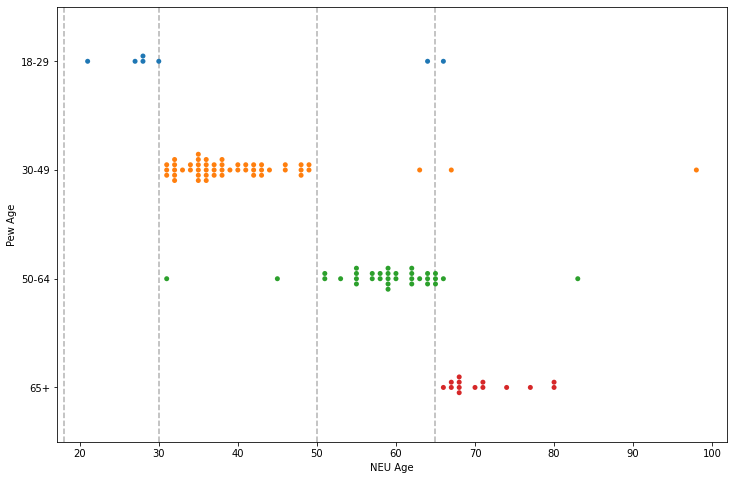

In [116]:
fig, ax = plt.subplots(figsize=(12, 8), facecolor='w')
sns.swarmplot('shifted_age', 'F_AGECAT', data=age, ax=ax)
for boundary in [18, 30, 50, 65]:
    ax.axvline(boundary, linestyle='--', color="black", alpha=0.3)
ax.set_xlabel("NEU Age")
ax.set_ylabel("Pew Age")

### Combined match rates

In [117]:
all_match = gender.merge(party).merge(age).merge(race).loc[:, ["gender_match", "party_match", "age_match", "race_match"]]

In [118]:
all_match_no_na = all_match[pd.notnull(all_match).all(axis=1)]
print(len(all_match_no_na))
print(len(all_match[pd.notnull(all_match).any(axis=1)]))

97
101


There are 10 IDs for which there is at least one missing value. (For 7 of these, they're all missing.)

In [119]:
all_match_no_na.sum(axis=1).value_counts(normalize=True)

3.00   0.46
4.00   0.39
2.00   0.13
0.00   0.01
dtype: float64

Mismatches are not concentrated to a few problematic records (aside from the missing ones).

## Behavior

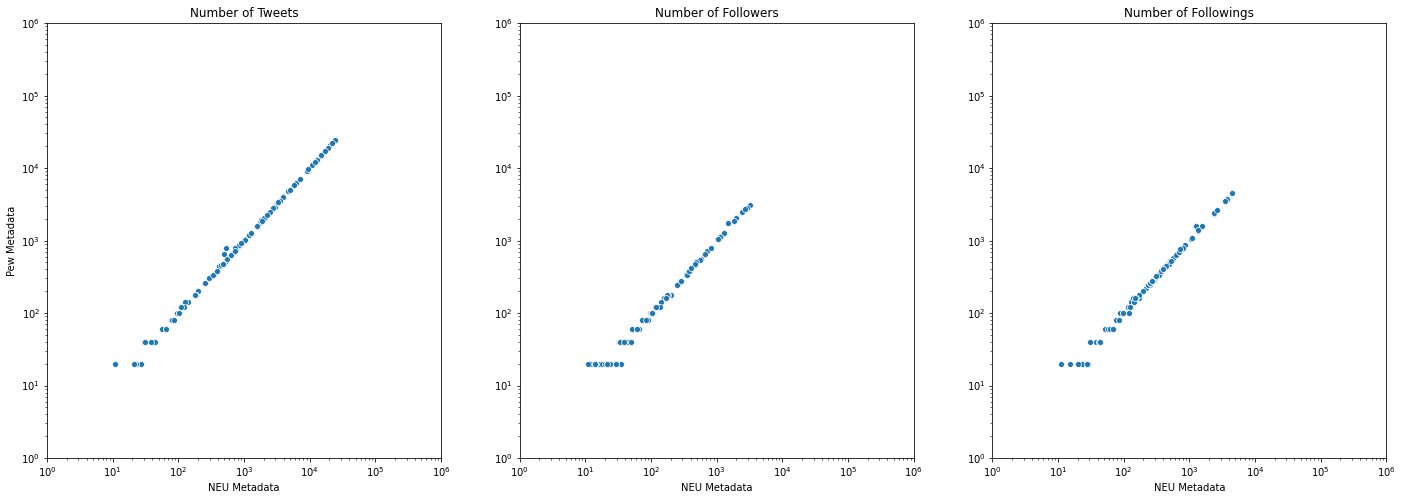

In [120]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), facecolor='w')

sns.scatterplot("statuses_count", "total_tweets", data=kp_df, ax=ax1)
sns.scatterplot("followers_count", "total_followers", data=kp_df, ax=ax2)
sns.scatterplot("friends_count", "total_followings", data=kp_df, ax=ax3)
for ax in (ax1, ax2, ax3):
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(1, 10**6)
    ax.set_ylim(1, 10**6)
    ax.set_xlabel("NEU Metadata")
    ax.set_ylabel("")
ax1.set_ylabel("Pew Metadata")
ax1.set_title("Number of Tweets")
ax2.set_title("Number of Followers")
ax3.set_title("Number of Followings")

fig.show()

# Round 2

In [121]:
hashes = pd.read_csv("./hash/hashed_neu_twids_v2.txt", sep="\t", names=["id", "hash"], dtype="str")
demog = pd.read_csv(DEMOG_FILE, sep='\t', names=list(DEMOG_SCHEMA.keys()), dtype=DEMOG_SCHEMA)
#pew_demog = pd.read_csv(f"{EXTERNAL_DATA_DIR}/panel_intersection.csv", dtype={'id': 'str', 'total_tweets': np.int64})

In [122]:
pew_demog = pd.read_csv(f"{EXTERNAL_DATA_DIR}/atp_overlap.csv", dtype={'id': 'str', 'total_tweets': np.int64})

In [123]:
pew_demog.F_REG.value_counts(dropna=False,normalize=True)

You are ABSOLUTELY CERTAIN that you are registered to vote at your current address   0.82
You are PROBABLY registered, but there is a chance your registration has lapsed      0.08
NaN                                                                                  0.07
You are NOT registered to vote at your current address                               0.03
Name: F_REG, dtype: float64

In [124]:
pew_demog = pew_demog.merge(hashes, "left", "hash")
merged_df = pew_demog.merge(demog, "left", "id")

# bring in WRU here before dropping ID
merged_df.race.fillna("Uncoded", inplace=True)
wru = pd.read_csv(WRU_IMPUTATIONS_FILE,
                  sep='\t',
                  dtype={'id_str': 'str'}).rename({'id_str': 'id'}, axis=1)
wru['imputed_race'] = wru['imputed_race']

merged_df = merged_df.merge(wru, how='left', on='id').drop(['pred.whi', 'pred.bla', 'pred.his', 'pred.asi', 'pred.oth'], axis=1)

# def combine_race(ts, wru):
#     if ts == "Uncoded": # NOTE/TODO: could be ['Uncoded', 'Other']
#         return wru
#     else:
#         return ts

# merged_df['combined_race'] = merged_df.apply(lambda x: combine_race(x['race'], x['imputed_race']), axis=1)

In [125]:
merged_df = merged_df.drop("id", axis=1)
merged_df.drop(columns=['hash', 'first_tweet', 'last_tweet', 'user_created_at', 'state', 'statuses_count', 'favourites_count', 'followers_count', 'friends_count']).head()

,Unnamed: 0,F_PARTY_FINAL,F_RACETHN,F_AGECAT,F_SEX,F_REG,F_CREGION,F_METRO,num_tweets,age,gender,race,party,cd,zip,county_fips,partisan_score,registration_status,verified,imputed_race
0,1,Independent,White non-Hispanic,50-64,Male,You are ABSOLUTELY CERTAIN that you are regist...,South,Metropolitan,501,82.00,Female,Caucasian,Democrat,2.00,85710,19,98.80,1.00,False,Caucasian
1,2,Republican,White non-Hispanic,65+,Male,You are ABSOLUTELY CERTAIN that you are regist...,South,Metropolitan,214,29.00,Female,Caucasian,Democrat,21.00,33462,99,95.10,1.00,False,Caucasian
2,3,Independent,Other,30-49,Female,You are ABSOLUTELY CERTAIN that you are regist...,South,Metropolitan,230,47.00,Female,Native American,Democrat,1.00,74063,143,96.40,1.00,False,Other
3,4,Independent,Hispanic,30-49,Female,You are ABSOLUTELY CERTAIN that you are regist...,Northeast,Metropolitan,90,38.00,Female,Caucasian,Unaffiliated,3.00,75093,85,48.20,1.00,False,Caucasian
4,5,Democrat,White non-Hispanic,30-49,Female,You are ABSOLUTELY CERTAIN that you are regist...,Northeast,Metropolitan,812,48.00,Female,Caucasian,Unaffiliated,8.00,77861,185,20.30,1.00,False,Caucasian


In [126]:
(merged_df["F_SEX"] == merged_df["gender"]).mean()

0.4794520547945205

In [127]:
all_df = pd.concat([kp_df, atp_df], ignore_index=True)

In [128]:
vra_df = all_df[all_df.state.isin(["AL", "GA", "LA", "MS", "SC", "VA", "AK", "AZ", "TX"])]

In [129]:
race = vra_df.loc[:, ['hash', 'pew_race', 'F_RACETHN']]
race['race_match'] = race['pew_race'] == race['F_RACETHN']
race.loc[pd.isnull(race['pew_race']), "race_match"] = np.nan
race.fillna("Unknown").groupby("F_RACETHN").pew_race.value_counts()

F_RACETHN           pew_race          
Black non-Hispanic  Black non-Hispanic     1
                    White non-Hispanic     1
Hispanic            Hispanic               1
White non-Hispanic  White non-Hispanic    19
Name: pew_race, dtype: int64

In [130]:
atp_df[atp_df.state.isin(["AL", "GA", "LA", "MS", "SC", "VA", "AK", "AZ", "TX"])].drop(columns=['hash', 'total_tweets', 'total_followings', 'n_tweets', 'first_tweet', 'last_tweet', 'user_created_at', 'state', 'statuses_count', 'favourites_count', 'followers_count', 'friends_count'])

,Unnamed: 0,F_SEX,F_PARTY_FINAL,F_AGECAT,F_RACETHN,total_followers,one_impeach,num_tweets,age,gender,...,registration_status,verified,imputed_race,pew_race,pew_imputed_race,pew_party,tsmart_party,pew_tsmart_party,shifted_age,pew_age
16,17,Male,Democrat,30-49,Black non-Hispanic,1040,1,18039,45.00,Male,...,1.00,False,Caucasian,Black non-Hispanic,White non-Hispanic,Independent,Independent,Independent,47.00,30-49
18,19,Male,Independent,65+,White non-Hispanic,1860,0,7872,65.00,Male,...,1.00,False,NaN,White non-Hispanic,NaN,Independent,Republican,Republican,67.00,65+
21,22,Female,Independent,18-29,Black non-Hispanic,580,0,8233,27.00,Female,...,1.00,False,African-American,White non-Hispanic,Black non-Hispanic,Independent,Democrat,Democrat,29.00,18-29
26,27,Female,Republican,50-64,White non-Hispanic,200,0,141,60.00,Female,...,1.00,False,Caucasian,White non-Hispanic,White non-Hispanic,Republican,Republican,Republican,62.00,50-64
27,28,Female,Democrat,30-49,White non-Hispanic,200,0,90,38.00,Female,...,1.00,False,Caucasian,White non-Hispanic,White non-Hispanic,Independent,Independent,Independent,40.00,30-49
32,33,Female,Independent,30-49,White non-Hispanic,200,0,5277,47.00,Female,...,1.00,False,Hispanic,White non-Hispanic,Hispanic,Democrat,Democrat,Democrat,49.00,30-49
34,35,Female,Republican,50-64,White non-Hispanic,260,0,812,48.00,Female,...,1.00,False,Caucasian,White non-Hispanic,White non-Hispanic,Independent,Republican,Republican,50.00,50-64
39,40,Female,Republican,30-49,White non-Hispanic,40,0,669,42.00,Female,...,1.00,False,Caucasian,White non-Hispanic,White non-Hispanic,Independent,Republican,Republican,44.00,30-49
52,53,Female,Democrat,50-64,White non-Hispanic,280,1,3049,51.00,Female,...,1.00,False,Caucasian,White non-Hispanic,White non-Hispanic,Independent,Democrat,Democrat,53.00,50-64
54,55,Male,Republican,30-49,White non-Hispanic,900,0,195,37.00,Male,...,1.00,False,Caucasian,White non-Hispanic,White non-Hispanic,Republican,Republican,Republican,39.00,30-49
